In [1]:
import pandas as pd
pd.options.display.max_columns = 200

import numpy as np
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

# увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 18, 6
rcParams['font.size'] = 16
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 13
rcParams['ytick.labelsize'] = 13

# Данные

Зайдите на https://www.drivendata.org/ и зарегистрируйтесь. Для сегодняшней домашки будем данные брать именно отсюда.

Нас интересует конкурс https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/ .
В нем представлены данные, собранные [Taarifa](taarifa.org) и [Танзанийским Министерством Воды и Ирригации](https://www.maji.go.tz/?q=en).

Постановка задачи следующая: 
На территории Танзании установлено множество водяных насосов, которые спасают местное население от жажды. В зависимости от того, кем и когда установлен насос, а также зная, как им распоряжаются, можно попытаться предположить, какие из них функционируют, какие нуждаются в ремонте и какие не работают вовсе. 

Этим мы и займемся, а заодно и прокачаемся в подборе гиперпараметров алгоритмов.

In [2]:
train_X, train_y = pd.read_csv( # путь к вашему файлу train.csv
    'data/WaterTable/train.csv'
), pd.read_csv( # путь к вашему файлу trainLabels.csv
    'data/WaterTable/trainLabels.csv'
)
df = pd.merge(train_X, train_y, how='left')

df_test = pd.read_csv( # путь к вашему файлу test.csv
    'data/WaterTable/test.csv'
)

In [3]:
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Предобработка

<div class="panel panel-warning">
    <div class="panel-heading">
        <h3 class="panel-title">Обратите внимание</h3> 
    </div>
</div>

Предобработка - опциональный блок, и у себя подготовить данные вы можете полностью по-своему.

__Единственное замечание:__ если решите подготавливать данные самостоятельно, замените странную строку `"other - mkulima/shinyanga"` на просто `"other"`, так как в тесте только `"other"`.
```python
df.loc[df.extraction_type == 'other - mkulima/shinyanga', 'extraction_type'] = 'other'
```

In [4]:
def reduce_factor_levels(df, column_name, limit=None, top=None, name=None):
    assert(limit is not None or top is not None), 'Specify limit ot top'
    if top is None:
        top = df[column_name].value_counts()[:limit].index
    if name is None:
        name = '%s_OTHER' % column_name
    df.loc[~df[column_name].isin(top), column_name] = name
    return top

In [5]:
top = reduce_factor_levels(df, 'funder', 10)
reduce_factor_levels(df_test, 'funder', top=top);

top = reduce_factor_levels(df, 'installer', 10)
reduce_factor_levels(df_test, 'installer', top=top);

In [6]:
#drop = ['wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code', 'lga', 'ward', 'recorded_by', 'scheme_name']

drop = ['wpt_name', 'num_private', 'district_code', 'region_code', 'subvillage']  # 

df.drop(drop, axis=1, inplace=True)
df_test.drop(drop, axis=1, inplace=True)

In [7]:
df.loc[df.scheme_management == 'None', 'scheme_management'] = ''
df.loc[df.scheme_management.isnull(), 'scheme_management'] = ''

df_test.loc[df_test.scheme_management.isnull(), 'scheme_management'] = ''

In [8]:
df['construction_date_known'] = (df.construction_year > 0).astype(np.int32)
df_test['construction_date_known'] = (df_test.construction_year > 0).astype(np.int32)

In [9]:
min_year = df[df.construction_year > 0].construction_year.min() // 10 - 1

df['construction_decade'] = df.construction_year // 10 - min_year
df_test['construction_decade'] = df_test.construction_year // 10 - min_year

df.loc[df.construction_decade < 0, 'construction_decade'] = 0
df_test.loc[df_test.construction_decade < 0, 'construction_decade'] = 0

In [10]:
top = reduce_factor_levels(df, 'construction_year', 20)
reduce_factor_levels(df_test, 'construction_year', top=top);

In [11]:
df.loc[df.extraction_type == 'other - mkulima/shinyanga', 'extraction_type'] = 'other'

In [12]:
heights = np.arange(-1, df.gps_height.max()+500, 500)
height_labels = list(range(len(heights)-1))

df['gps_height_rounded'] = pd.cut(df.gps_height, bins=heights, labels=height_labels)
df_test['gps_height_rounded'] = pd.cut(df_test.gps_height, bins=heights, labels=height_labels)

#df.drop(['gps_height'], axis=1, inplace=True)
#df_test.drop(['gps_height'], axis=1, inplace=True)

In [13]:
#pops = np.arange(-1, df.population.max()+500, 500)
#pops_labels = list(range(len(pops)-1))

#df['pop_rounded'] = pd.cut(df.population, bins=pops, labels=pops_labels)
#df_test['pop_rounded'] = pd.cut(df_test.population, bins=pops, labels=pops_labels)

#df.drop(['population'], axis=1, inplace=True)
#df_test.drop(['population'], axis=1, inplace=True)

In [14]:
#df.drop(['date_recorded'], axis=1, inplace=True)
#df_test.drop(['date_recorded'], axis=1, inplace=True)

In [15]:
df.public_meeting.fillna(True, inplace=True)
df_test.public_meeting.fillna(True, inplace=True)

In [16]:
df.permit.fillna(True, inplace=True)
df_test.permit.fillna(True, inplace=True)

In [17]:
df.gps_height_rounded.fillna(0, inplace=True)
df_test.gps_height_rounded.fillna(0, inplace=True)

# Визуализация

In [17]:
df.head()

,id,amount_tsh,date_recorded,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded
0,69572,6000.0,2011-03-14,funder_OTHER,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1,4,2,0
1,8776,0.0,2013-03-06,funder_OTHER,installer_OTHER,34.698766,-2.147466,Lake Victoria,Mara,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1,6,2,0
2,34310,25.0,2013-02-25,funder_OTHER,installer_OTHER,37.460664,-3.821329,Pangani,Manyara,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1,5,1,0
3,67743,0.0,2013-01-28,Unicef,installer_OTHER,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,True,VWC,True,construction_year_OTHER,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1,3,0,0
4,19728,0.0,2011-07-13,funder_OTHER,installer_OTHER,31.130847,-1.825359,Lake Victoria,Kagera,True,,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0


### Визуализируем качество воды в разных регионах

In [114]:
df.quality_group.value_counts()

good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64

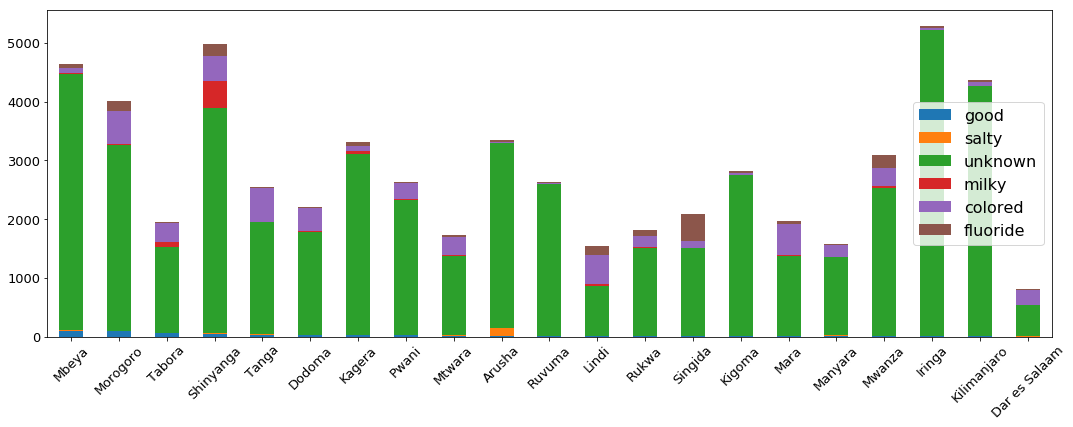

In [115]:
quality_groupInRegions = df.groupby('region')['quality_group'].value_counts().to_dict()

results = pd.DataFrame(data = quality_groupInRegions, index=[0]).stack().fillna(0).transpose()
results.columns = pd.Index(['good', 'salty', 'unknown', 'milky', 'colored', 'fluoride'])
results['total'] = results.good + results.salty + results.unknown + results.milky + results.colored + results.fluoride
results.sort_values(by='good', ascending=False, inplace=True)
results[['good', 'salty', 'unknown', 'milky', 'colored', 'fluoride']].plot(kind='bar', stacked=True, rot=45);

### Визуализируем геоданные о текущем статусе водяных насосов

In [116]:
from folium import Map, CircleMarker
import colorsys

#Просто карта
tanzania_map = Map(location=(-2.147466, 34.698766), tiles='Mapbox Bright', zoom_start=6)
#tanzania_map

In [117]:
#в качестве target сделаем текущий статус
df.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [118]:
df['target'] = 0 #non functional
df.loc[df.status_group == 'functional needs repair', 'target'] = 1
df.loc[df.status_group == 'functional', 'target'] = 2
df.head()

,id,amount_tsh,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded,target
0,69572,6000.0,funder_OTHER,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1,4,2,0,2
1,8776,0.0,funder_OTHER,installer_OTHER,34.698766,-2.147466,Lake Victoria,Mara,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1,6,2,0,2
2,34310,25.0,funder_OTHER,installer_OTHER,37.460664,-3.821329,Pangani,Manyara,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1,5,1,0,2
3,67743,0.0,Unicef,installer_OTHER,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,True,VWC,True,construction_year_OTHER,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1,3,0,0,0
4,19728,0.0,funder_OTHER,installer_OTHER,31.130847,-1.825359,Lake Victoria,Kagera,True,,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0,2


In [119]:
# Карта с отмеченными источниками
get_radius = lambda x: (x - min_)/(max_ - min_)*7 + 3

rgbhex = lambda rgb: '#'+"".join("%02X" % i for i in rgb)
get_fill_color = lambda x: rgbhex(tuple(int(i * 255) for i in \
                                   colorsys.hsv_to_rgb(x/max_*120.0/360.0, 0.56, 0.84)))
get_border_color = lambda x: rgbhex(tuple(int(i * 255) for i in \
                                   colorsys.hsv_to_rgb(x/max_*120.0/360.0, 0.78, 0.36)))

add_marker = lambda lat, lon, target: \
    CircleMarker((lat, lon), 
                 radius     = get_radius(target), 
                 color      = get_border_color(target),
                 fill_color = get_fill_color(target), 
                 popup='Lat: %.3f; Lon: %.3f' % (lat, lon),
                    )\
    .add_to(tanzania_map)

In [120]:
min_, max_ = df[['target']].describe().loc['min'][0], df[['target']].describe().loc['max'][0]

In [121]:
df.sample(n=1000).apply(lambda row: add_marker(row['latitude'], row['longitude'], row['target']), axis=1);

In [17]:
#tanzania_map

In [123]:
df = df.drop(['target'], axis=1)
df.head()

,id,amount_tsh,funder,installer,longitude,latitude,basin,region,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,construction_date_known,construction_decade,gps_height_rounded,pop_rounded
0,69572,6000.0,funder_OTHER,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,True,VWC,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1,4,2,0
1,8776,0.0,funder_OTHER,installer_OTHER,34.698766,-2.147466,Lake Victoria,Mara,True,Other,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1,6,2,0
2,34310,25.0,funder_OTHER,installer_OTHER,37.460664,-3.821329,Pangani,Manyara,True,VWC,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1,5,1,0
3,67743,0.0,Unicef,installer_OTHER,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,True,VWC,True,construction_year_OTHER,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,1,3,0,0
4,19728,0.0,funder_OTHER,installer_OTHER,31.130847,-1.825359,Lake Victoria,Kagera,True,,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,0,0,0,0


# Модели

In [18]:
X, y, X_test = df.drop(['id', 'status_group'], axis=1), \
               df.status_group, \
               df_test.drop(['id'], axis=1)

In [19]:
X.head(1)

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,construction_date_known,construction_decade,gps_height_rounded
0,6000.0,2011-03-14,funder_OTHER,1390,installer_OTHER,34.938093,-9.856322,Lake Nyasa,Iringa,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,1,4,2


<div class="panel panel-warning">
    <div class="panel-heading">
        <h3 class="panel-title">Обратите внимание</h3> 
    </div>
</div>

Вот эта функция ниже - опять мои штуки-дрюки, и можно кодировать данные по-своему.

In [20]:
def prepare(X_train, X_test):
    from sklearn.preprocessing import StandardScaler
    from sklearn.feature_extraction import DictVectorizer
    
    objects = X_train.select_dtypes(include=['O']).columns.values
    numeric = X_train.select_dtypes(exclude=['O']).columns.values
    
    dv = DictVectorizer(sparse=False)
    data_encoded_tr = dv.fit_transform(X_train[objects].to_dict(orient='records'))
    data_encoded_ts = dv.transform(X_test[objects].to_dict(orient='records'))

    ss = StandardScaler()
    data_scaled_tr = ss.fit_transform(X_train[numeric])
    data_scaled_ts = ss.transform(X_test[numeric])
    
    train = np.hstack((data_encoded_tr, data_scaled_tr))
    test  = np.hstack((data_encoded_ts, data_scaled_ts))
    return train, test

In [21]:
x_train, x_test = prepare(X, X_test)

In [22]:
from sklearn.preprocessing import LabelEncoder

In [23]:
y_encoder = LabelEncoder()
y = y_encoder.fit_transform(y)

In [24]:
x_train.shape

(59400, 5472)

In [25]:
x_test.shape

(14850, 5472)

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 1.</h3> 
    </div>
</div>

Возьмите тетрадку с сегодняшнего занятия и, руководствуясь советами по настройке, заделайте лучший GBM в мире! Не забудьте отправлять результаты на drivendata и хвастаться в чате о результатах.

In [254]:
SEED = 1234
np.random.seed = SEED

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [258]:
clf = GradientBoostingClassifier(random_state=SEED, n_estimators=10, learning_rate=0.01,subsample=0.8, max_depth=4) 
scores = cross_val_score(clf, x_train, y)
np.mean(scores), 2*np.std(scores)

(0.69139730639730634, 0.0025182844378876025)

In [259]:
clf = clf.fit(x_train, y)
print('Mean score:', scores.mean())

Mean score: 0.691397306397


In [260]:
y_te = clf.predict(x_test)
y_te

array([0, 0, 0, ..., 0, 0, 2], dtype=int64)

In [261]:
ans_nn2 = pd.DataFrame({'id': df_test['id'], 'status_group': y_encoder.inverse_transform(y_te)})
ans_nn2.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [262]:
ans_nn.to_csv('ans_gbm.csv', index=False)

<div class="panel panel-info" style="margin: 50px 0 0 0">
    <div class="panel-heading">
        <h3 class="panel-title">Задание 2.</h3> 
    </div>
</div>

Выберите любой из сторонних фреймворков по своему усмотрению:
* XGBoost
* LightGBM
* H2O
* CatBoost

Установите, прокачайте его, побейте GBM от sklearn.

### Опробуем lightgbm

In [26]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier

In [64]:
#clf2 = LGBMClassifier(max_bin=475,learning_rate=0.13,n_estimators=140,num_leaves=131)
#clf2 = LGBMClassifier(max_bin=400,learning_rate=0.13,n_estimators=140,num_leaves=131)

clf2 = LGBMClassifier(max_bin=400,learning_rate=0.134,n_estimators=151,num_leaves=131)
 
scores = cross_val_score(clf2, x_train, y)
np.mean(scores), 2*np.std(scores)

(0.80742424242424249, 0.0041631196002892687)

In [65]:
clf2 = clf2.fit(x_train, y)

In [66]:
y_te = clf2.predict(x_test)
y_te

array([0, 0, 0, ..., 0, 0, 2], dtype=int64)

In [67]:
ans_nn = pd.DataFrame({'id': df_test['id'], 'status_group': y_encoder.inverse_transform(y_te)})
ans_nn.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [68]:
ans_nn.to_csv('ans_lightgbm.csv', index=False)

### Опробуем catboost

In [265]:
from catboost import Pool, CatBoostClassifier

In [266]:
clf3 = CatBoostClassifier(random_seed=SEED, iterations=500, learning_rate=0.03, depth=6)

scores = cross_val_score(clf3, x_train, y, n_jobs=-1)
np.mean(scores), 2*np.std(scores)

(0.51146464646464651, 0.0013627007639629043)

In [267]:
clf3 = clf3.fit(x_train, y)

In [286]:
y_te = clf3.predict(x_test)
y_te

array([ 0.,  0.,  0., ...,  0.,  0.,  1.])

In [290]:
arr = []

i = 0
while i < len(y_te):
    arr.append(int(y_te[i]))
    i += 1
    
#arr

In [291]:
ans_nn = pd.DataFrame({'id': df_test['id'], 'status_group': y_encoder.inverse_transform(arr)})
ans_nn.head()

,id,status_group
0,50785,functional
1,51630,functional
2,17168,functional
3,45559,functional needs repair
4,49871,functional


In [292]:
ans_nn.to_csv('ans_catboost.csv', index=False)

### Опробуем H2O

In [27]:
import h2o

In [31]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from sklearn.model_selection import cross_val_score

In [29]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-win64) (build 25.121-b15, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Alice\AppData\Local\Temp\tmpbrdqc9kx
  JVM stdout: C:\Users\Alice\AppData\Local\Temp\tmpbrdqc9kx\h2o_Alice_started_from_python.out
  JVM stderr: C:\Users\Alice\AppData\Local\Temp\tmpbrdqc9kx\h2o_Alice_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,06 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,2 months and 6 days
H2O cluster name:,H2O_from_python_Alice_vg1elo
H2O cluster total nodes:,1
H2O cluster free memory:,1.778 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None
